In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:


# Define dataset paths and labels
data_dirs = {
    "falling": 0,
    "sitting": 1,
    "standing": 2
}

base_path = "increase_data"
X, Y = [], []

# Load data
for category, label in data_dirs.items():
    folder_path = os.path.join(base_path, category)
    
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # Skip empty files
        if os.stat(file_path).st_size == 0:
            print(f"Skipping empty file: {file_path}")
            continue

        try:
            # Read CSV file (no header, raw data)
            data = pd.read_csv(file_path, header=None).values  

            # Ensure correct shape (100, 132)
            if data.shape == (100, 132):
                X.append(data)
                Y.append(label)
            else:
                print(f"Skipping file due to incorrect shape: {file_path} -> {data.shape}")

        except pd.errors.EmptyDataError:
            print(f"Skipping empty file (exception caught): {file_path}")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Convert to NumPy arrays
X = np.array(X)  # Shape: (num_samples, 100, 132)
Y = np.array(Y)  # Shape: (num_samples,)

# Ensure there is data before splitting
if len(X) == 0:
    raise ValueError("No valid data found. Check your files!")

# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


# Output dataset shape
print(f"X_train shape: {X_train.shape}")  # Expected: (num_train_samples, 100, 132)
print(f"Y_train shape: {Y_train.shape}")  # Expected: (num_train_samples,)
print(f"X_test shape: {X_test.shape}")   # Expected: (num_test_samples, 100, 132)
print(f"Y_test shape: {Y_test.shape}")   # Expected: (num_test_samples,)


X_train shape: (192, 100, 132)
Y_train shape: (192,)
X_test shape: (60, 100, 132)
Y_test shape: (60,)


In [3]:
model  = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation="softmax"))
model.compile(optimizer="adam", metrics=['accuracy'], loss="sparse_categorical_crossentropy")

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:

# Train model
checkpoint = ModelCheckpoint(
    filepath='model_checkpoints/best_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# history = model.fit(X_train, Y_train, epochs=16, batch_size=32, validation_data=(X_test, Y_test))
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,  # or your preferred number
    batch_size=64,
    callbacks=[checkpoint, early_stopping],  # We'll add ModelCheckpoint here
)
model.save("model.h5")


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4306 - loss: 1.0833
Epoch 1: val_loss improved from inf to 0.95956, saving model to model_checkpoints/best_model_epoch_01_val_loss_0.9596.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.4622 - loss: 1.0768 - val_accuracy: 0.8125 - val_loss: 0.9596
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8047 - loss: 0.9247
Epoch 2: val_loss improved from 0.95956 to 0.70117, saving model to model_checkpoints/best_model_epoch_02_val_loss_0.7012.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8105 - loss: 0.9146 - val_accuracy: 1.0000 - val_loss: 0.7012
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9635 - loss: 0.6693
Epoch 3: val_loss improved from 0.70117 to 0.45208, saving model to model_checkpoints/best_model_epoch_03_val_loss_0.4521.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9609 - loss: 0.6590 - val_accuracy: 1.0000 - val_loss: 0.4521
Epoch 4/30
3/3 ━━━━━━━━━━━

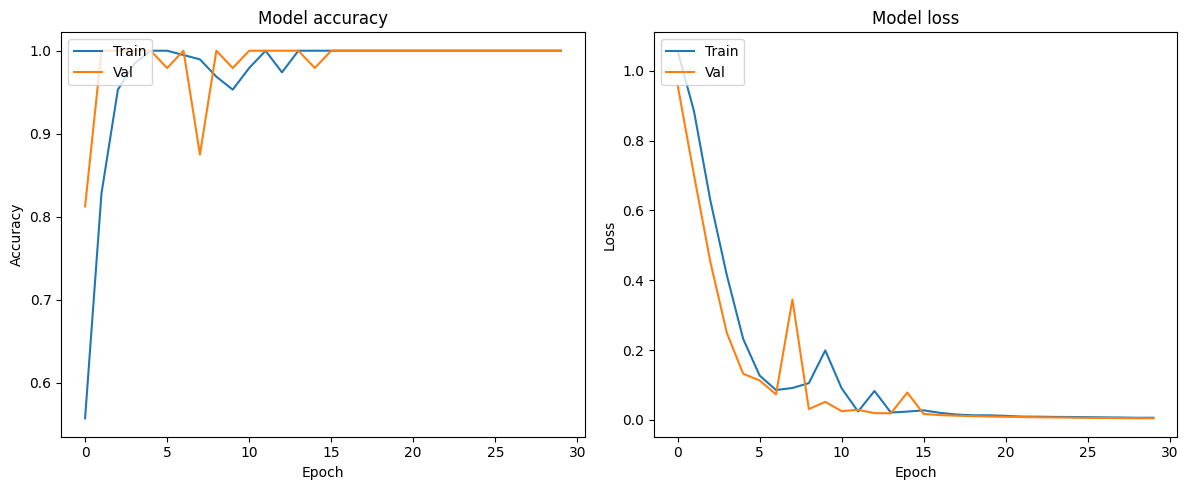

In [6]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()


Base on this chart, we can see 
#### Accuracy Plot (Left):
    1. Validation accuracy spikes quickly and becomes stable at ~epoch 8.
    2. Training accuracy slowly catches up but also stabilizes.

#### Loss Plot (Right):
    1. Both training and validation loss drop rapidly in early epochs.
    2. Validation loss is lowest around epoch 7–9.
    3. After epoch 10, both loss curves are very close to zero, but training loss continues improving, while validation is flat — a sign of possible overfitting.
#### Where to stop
we should stop at epoch 8-9
    1. Validation accuracy is already at its peak (~100%).
    2. Validation loss is lowest there.
    3. After that, training loss continues to drop while validation stays flat — which means the model is starting to overfit to the training data.

In [7]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0045
Test Accuracy: 1.0000
Test Loss: 0.0044


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [14]:
y_pred = np.array(y_pred)
y_true = np.array(Y_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion Matrix:

[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]
